In [21]:
import sbi 
import random
import numpy as np
import torch as th 
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm, trange

from sbi.analysis import pairplot
from sbi.inference import NPE, NLE 
from sbi.utils import BoxUniform
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
from sbi.inference.posteriors.ensemble_posterior import EnsemblePosterior
from sbi.utils.simulation_utils import simulate_for_sbi
from sbi.inference import MCABC
from sbibm.metrics import c2st

from typing import Sequence

from emnets.simulator import gaussian_simulator

import warnings
warnings.filterwarnings('ignore')

In [22]:
seed = 42
random.seed(seed)
np.random.seed(seed)
th.manual_seed(seed)

In [23]:
!pwd

/Users/hayden/Desktop/code/research/goncalves-lab/emulator-networks/notebooks


In [26]:
p = '../src'
nle = np.loadtxt(f"{p}/nle.txt", delimiter=",")
snle = np.loadtxt(f"{p}/snle.txt", delimiter=",")
esnle = np.loadtxt(f"{p}/esnle.txt", delimiter=",")

In [10]:
nle.shape

(3, 50)

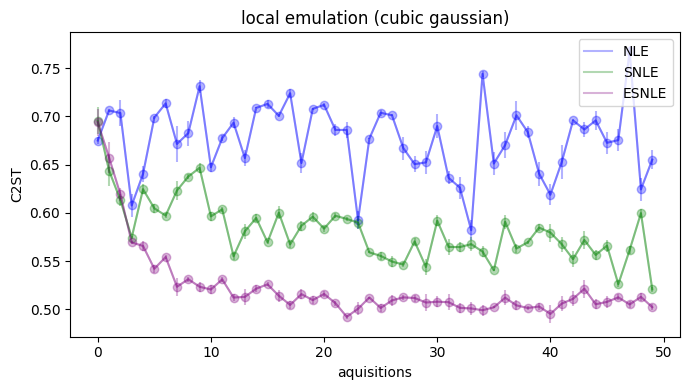

In [38]:
fig, ax = plt.subplots(figsize=(7, 4))
_, n = nle.shape 
a = .3
ax.plot(np.arange(n), nle.mean(axis=0), c='b', alpha=a, label='NLE')
ax.scatter(np.arange(n), nle.mean(axis=0), c='b', alpha=a)
ax.errorbar(np.arange(n), nle.mean(axis=0), yerr=nle.std(axis=0)/np.sqrt(n), c='b', alpha=a)

ax.plot(np.arange(n), snle.mean(axis=0), c='g', alpha=a, label='SNLE')
ax.scatter(np.arange(n), snle.mean(axis=0), c='g', alpha=a)
ax.errorbar(np.arange(n), snle.mean(axis=0), yerr=snle.std(axis=0)/np.sqrt(n), c='g', alpha=a)

ax.plot(np.arange(n), esnle.mean(axis=0), c='purple', alpha=a, label='ESNLE')
ax.scatter(np.arange(n), esnle.mean(axis=0), c='purple', alpha=a)
ax.errorbar(np.arange(n), esnle.mean(axis=0), yerr=snle.std(axis=0)/np.sqrt(n), c='purple', alpha=a)

ax.set_xlabel('aquisitions')
ax.set_ylabel('C2ST')


plt.title('local emulation (cubic gaussian)')
plt.legend(loc=1)
plt.tight_layout()
plt.savefig('unstable.png')
plt.show()

In [3]:
def gaussian_simulator(theta, n=1, cov=.99):
    if isinstance(theta, Sequence):
        return np.array([gaussian_simulator(t).squeeze() for t in theta])
    
    f = lambda t : (1.5 * t)**3 / 200
    x = np.random.normal(loc=f(theta), scale=cov, size=n)
    return x

In [4]:
def get_posterior_samples(prior, simulator, observation, n_samples=10000):
    prior, num_parameters, prior_returns_numpy = process_prior(prior)
    simulator = process_simulator(simulator, prior, prior_returns_numpy)
    check_sbi_inputs(simulator, prior)
    inference_method = MCABC(
        simulator=simulator,
        prior=prior,
        show_progress_bars=False,
    )
    output, _ = inference_method(
        x_o=observation,
        num_simulations=n_samples*100,
        quantile=.01,
        return_summary=True
    )
    return output

In [5]:
def run_nle_comparison(simulator, prior, obs, n_sims_init, n_aquisitions, n_samples=1000, n_repeats=3):
    # validate prior and simulator for sbi 
    prior, num_parameters, prior_returns_numpy = process_prior(prior)
    simulator = process_simulator(gaussian_simulator, prior, prior_returns_numpy)
    # use mcmc for ground truth posterior samples 
    mcmc_samples = get_posterior_samples(prior, simulator, obs, n_samples=n_samples)
    # simulate full dataset
    theta, x = simulate_for_sbi(simulator, prior, num_simulations=n_sims_init+n_aquisitions, show_progress_bar=False)    
    C2ST = np.ones((n_repeats, n_aquisitions))*-1
    for i in trange(n_repeats):
        for j in trange(n_aquisitions):
            # reset & retrain NLE
            inference = NLE(prior=prior)
            density_estimator = inference.append_simulations(theta[:n_sims_init+j], x[:n_sims_init+j]).train(show_train_summary=False)
            # generate posterior samples
            posterior = inference.build_posterior(density_estimator)
            nle_samples = posterior.sample((n_samples,), x=obs, show_progress_bars=False)
            # compare MCMC with NLE w/ C2ST
            C2ST[i][j] = c2st(nle_samples, mcmc_samples).item()
    # returns (n_repeat x n_aquisitions) matrix
    return C2ST
    

In [6]:
def run_snle_comparison(simulator, prior, obs, n_sims_init, n_aquisitions, n_samples=1000, n_repeats=3):
    # validate prior and simulator for sbi 
    prior, num_parameters, prior_returns_numpy = process_prior(prior)
    simulator = process_simulator(gaussian_simulator, prior, prior_returns_numpy)
    # use mcmc for ground truth posterior samples 
    mcmc_samples = get_posterior_samples(prior, gaussian_simulator, obs, n_samples=n_samples)
    # simulate full dataset
    theta_init, x_init = simulate_for_sbi(simulator, prior, num_simulations=n_sims_init, show_progress_bar=False)    
    C2ST = np.ones((n_repeats, n_aquisitions))*-1
    for i in trange(n_repeats):
        ## initial training loop 
        inference = NLE(prior=prior)
        density_estimator = inference.append_simulations(theta_init, x_init).train(show_train_summary=False)
        posterior = inference.build_posterior(density_estimator)
        ## this line is throwing an error for some reason
        #nle_samples = posterior.sample((n_samples,), x=obs, show_progress_bars=False)
        #print((n_samples,), type(n_samples))
        snle_samples = posterior.sample((n_samples,), x=obs, show_progress_bars=False)
        C2ST[i][0] = c2st(snle_samples, mcmc_samples).item()
        for j in trange(1, n_aquisitions):
            # set proposal distribution 
            proposal = posterior.set_default_x(obs)
            # simulate new data from proposal rather than prior
            theta, x = simulate_for_sbi(simulator, proposal, num_simulations=1, show_progress_bar=False)
            density_estimator = inference.append_simulations(theta, x).train(show_train_summary=False)
            posterior = inference.build_posterior(density_estimator)
            snle_samples = posterior.sample((n_samples,), x=obs, show_progress_bars=False)
            # compare MCMC with SNLE w/ C2ST
            C2ST[i][j] = c2st(snle_samples, mcmc_samples).item()
    # returns (n_repeat x n_aquisitions) matrix
    return C2ST


In [7]:
def run_esnle_comparison(simulator, prior, obs, n_sims_init, n_aquisitions, n_samples=1000, n_repeats=3, n_emulators=3):
    prior, num_parameters, prior_returns_numpy = process_prior(prior)
    simulator = process_simulator(gaussian_simulator, prior, prior_returns_numpy)
    mcmc_samples = get_posterior_samples(prior, gaussian_simulator, obs, n_samples=n_samples)
    theta_init, x_init = simulate_for_sbi(simulator, prior, num_simulations=n_sims_init, show_progress_bar=False)    
    C2ST = np.ones((n_repeats, n_aquisitions))*-1
    for i in trange(n_repeats):
        emulators = [NLE(prior=prior, show_progress_bars=False) for _ in range(n_emulators)]
        ensemble = []
        for inference in emulators:
            density_estimator = inference.append_simulations(theta_init, x_init).train()
            posterior = inference.build_posterior(density_estimator)
            ensemble.append(posterior)
        ensemble_posterior = EnsemblePosterior(ensemble)
        esnle_samples = posterior.sample((n_samples,), x=obs, show_progress_bars=False)
        C2ST[i][0] = c2st(esnle_samples, mcmc_samples).item()
        for j in range(1, n_aquisitions):
            proposal = ensemble_posterior.set_default_x(obs)
            theta_prop = proposal.sample((100,))
            likelihood_matrix = np.array([e.log_prob(theta_prop, obs).numpy() for e in ensemble])
            theta_star = theta_prop[np.argmax(likelihood_matrix.var(axis=0))]
            ## should we use processed simulator here?
            x = gaussian_simulator(theta_star)
            # cast as tensors
            x = th.Tensor(x).unsqueeze(-1)
            theta_star = th.Tensor(theta_star).unsqueeze(-1)
            for inference in emulators:
                density_estimator = inference.append_simulations(theta_star, x).train()
                posterior = inference.build_posterior(density_estimator)
                ensemble.append(posterior)
            ensemble_posterior = EnsemblePosterior(ensemble)
            esnle_samples = ensemble_posterior.sample((n_samples,), x=obs, show_progress_bars=False)
            C2ST[i][0] = c2st(esnle_samples, mcmc_samples).item()

    return C2ST


In [8]:
obs = th.tensor([3])
n_sims_init = 25
n_aquisitions = 50
n_repeats = 3
prior = BoxUniform(low=-8 * th.ones(1), high=8 * th.ones(1)) 

In [9]:
nle = run_nle_comparison(gaussian_simulator, prior, obs, n_sims_init, n_aquisitions)
snle = run_snle_comparison(gaussian_simulator, prior, obs, n_sims_init, n_aquisitions)
esnle = run_esnle_comparison(gaussian_simulator, prior, obs, n_sims_init, n_aquisitions)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

 Neural network successfully converged after 41 epochs.(1000,) <class 'int'>
 Neural network successfully converged after 40 epochs.(1000,) <class 'int'>
 Neural network successfully converged after 38 epochs.(1000,) <class 'int'>
 Neural network successfully converged after 38 epochs.(1000,) <class 'int'>
 Neural network successfully converged after 39 epochs.(1000,) <class 'int'>
 Neural network successfully converged after 52 epochs.(1000,) <class 'int'>
 Neural network successfully converged after 282 epochs.(1000,) <class 'int'>
 Neural network successfully converged after 39 epochs.(1000,) <class 'int'>
 Neural network successfully converged after 72 epochs.(1000,) <class 'int'>
 Neural network successfully converged after 243 epochs.(1000,) <class 'int'>
 Neural network successfully converged after 40 epochs.(1000,) <class 'int'>
 Neural network successfully converged after 55 epochs.(1000,) <class 'int'>
 Neural network successfully converged after 37 epochs.(1000,) <class 'int

  0%|          | 0/50 [00:00<?, ?it/s]

 Neural network successfully converged after 75 epochs.(1000,) <class 'int'>
 Neural network successfully converged after 426 epochs.(1000,) <class 'int'>
 Neural network successfully converged after 37 epochs.(1000,) <class 'int'>
 Neural network successfully converged after 62 epochs.(1000,) <class 'int'>
 Neural network successfully converged after 76 epochs.(1000,) <class 'int'>
 Neural network successfully converged after 37 epochs.(1000,) <class 'int'>
 Neural network successfully converged after 91 epochs.(1000,) <class 'int'>
 Neural network successfully converged after 37 epochs.(1000,) <class 'int'>
 Neural network successfully converged after 194 epochs.(1000,) <class 'int'>
 Neural network successfully converged after 175 epochs.(1000,) <class 'int'>
 Neural network successfully converged after 39 epochs.(1000,) <class 'int'>
 Neural network successfully converged after 103 epochs.(1000,) <class 'int'>
 Neural network successfully converged after 38 epochs.(1000,) <class 'i

  0%|          | 0/50 [00:00<?, ?it/s]

 Neural network successfully converged after 90 epochs.(1000,) <class 'int'>
 Neural network successfully converged after 40 epochs.(1000,) <class 'int'>
 Neural network successfully converged after 184 epochs.(1000,) <class 'int'>
 Neural network successfully converged after 48 epochs.(1000,) <class 'int'>
 Neural network successfully converged after 190 epochs.(1000,) <class 'int'>
 Neural network successfully converged after 50 epochs.(1000,) <class 'int'>
 Neural network successfully converged after 53 epochs.(1000,) <class 'int'>
 Neural network successfully converged after 204 epochs.(1000,) <class 'int'>
 Neural network successfully converged after 201 epochs.(1000,) <class 'int'>
 Neural network successfully converged after 62 epochs.(1000,) <class 'int'>
 Neural network successfully converged after 74 epochs.(1000,) <class 'int'>
 Neural network successfully converged after 42 epochs.(1000,) <class 'int'>
 Neural network successfully converged after 41 epochs.(1000,) <class 'i

  0%|          | 0/3 [00:00<?, ?it/s]

 Neural network successfully converged after 40 epochs.

  0%|          | 0/49 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.4135]])
x: tensor([[3.0266]])
 Neural network successfully converged after 88 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.1185]])
x: tensor([[4.6356]])
 Neural network successfully converged after 24 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[4.7209]])
x: tensor([[2.6760]])
 Neural network successfully converged after 28 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.6978]])
x: tensor([[3.2781]])
 Neural network successfully converged after 21 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.1676]])
x: tensor([[2.0645]])
 Neural network successfully converged after 21 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.0793]])
x: tensor([[5.2689]])
 Neural network successfully converged after 24 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.6617]])
x: tensor([[2.1278]])
 Neural network successfully converged after 38 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[4.7473]])
x: tensor([[-0.5507]])
 Neural network successfully converged after 24 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.2485]])
x: tensor([[3.9839]])
 Neural network successfully converged after 24 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.1677]])
x: tensor([[4.1987]])
 Neural network successfully converged after 23 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.5355]])
x: tensor([[2.9265]])
 Neural network successfully converged after 24 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.4849]])
x: tensor([[4.8178]])
 Neural network successfully converged after 25 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.4893]])
x: tensor([[4.7937]])
 Neural network successfully converged after 306 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.5707]])
x: tensor([[3.4675]])
 Neural network successfully converged after 33 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[7.1035]])
x: tensor([[6.5312]])
 Neural network successfully converged after 28 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.3641]])
x: tensor([[3.1014]])
 Neural network successfully converged after 43 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.7850]])
x: tensor([[3.7696]])
 Neural network successfully converged after 27 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.7089]])
x: tensor([[3.1930]])
 Neural network successfully converged after 41 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.5328]])
x: tensor([[2.8621]])
 Neural network successfully converged after 36 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.1851]])
x: tensor([[3.7487]])
 Neural network successfully converged after 23 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.2622]])
x: tensor([[1.6423]])
 Neural network successfully converged after 28 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.0286]])
x: tensor([[2.4046]])
 Neural network successfully converged after 28 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.0975]])
x: tensor([[1.2151]])
 Neural network successfully converged after 28 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.0809]])
x: tensor([[2.7635]])
 Neural network successfully converged after 21 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.3160]])
x: tensor([[4.0738]])
 Neural network successfully converged after 21 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.8711]])
x: tensor([[3.3476]])
 Neural network successfully converged after 44 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.9030]])
x: tensor([[7.1039]])
 Neural network successfully converged after 37 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.9148]])
x: tensor([[7.5794]])
 Neural network successfully converged after 49 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.9672]])
x: tensor([[1.6153]])
 Neural network successfully converged after 28 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.5598]])
x: tensor([[1.4319]])
 Neural network successfully converged after 38 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.8234]])
x: tensor([[3.0328]])
 Neural network successfully converged after 26 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[-2.2634]])
x: tensor([[-0.1515]])
 Neural network successfully converged after 58 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.8852]])
x: tensor([[4.3404]])
 Neural network successfully converged after 42 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.4647]])
x: tensor([[1.8385]])
 Neural network successfully converged after 56 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.6372]])
x: tensor([[2.7587]])
 Neural network successfully converged after 37 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.4553]])
x: tensor([[6.8197]])
 Neural network successfully converged after 52 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.1402]])
x: tensor([[2.0148]])
 Neural network successfully converged after 29 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.0928]])
x: tensor([[4.1976]])
 Neural network successfully converged after 32 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.1417]])
x: tensor([[2.7259]])
 Neural network successfully converged after 23 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.2030]])
x: tensor([[4.8331]])
 Neural network successfully converged after 32 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.4862]])
x: tensor([[2.7671]])
 Neural network successfully converged after 35 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.6529]])
x: tensor([[4.6268]])
 Neural network successfully converged after 27 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[-2.1828]])
x: tensor([[1.3444]])
 Neural network successfully converged after 28 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.8104]])
x: tensor([[1.8154]])
 Neural network successfully converged after 25 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[4.9726]])
x: tensor([[2.8580]])
 Neural network successfully converged after 47 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.5561]])
x: tensor([[3.7669]])
 Neural network successfully converged after 36 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[-2.1858]])
x: tensor([[-1.1437]])
 Neural network successfully converged after 23 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.4231]])
x: tensor([[3.3043]])
 Neural network successfully converged after 40 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.9200]])
x: tensor([[2.0292]])
 Neural network successfully converged after 38 epochs.

  0%|          | 0/49 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[3.6442]])
x: tensor([[1.2575]])
 Neural network successfully converged after 315 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.1045]])
x: tensor([[4.9001]])
 Neural network successfully converged after 29 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.2921]])
x: tensor([[2.2296]])
 Neural network successfully converged after 24 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[-1.3377]])
x: tensor([[-0.8930]])
 Neural network successfully converged after 24 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.3106]])
x: tensor([[1.3639]])
 Neural network successfully converged after 23 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.1454]])
x: tensor([[1.8926]])
 Neural network successfully converged after 34 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.9944]])
x: tensor([[3.6390]])
 Neural network successfully converged after 63 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.9828]])
x: tensor([[1.9165]])
 Neural network successfully converged after 30 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.2564]])
x: tensor([[3.5615]])
 Neural network successfully converged after 25 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.5155]])
x: tensor([[3.1143]])
 Neural network successfully converged after 32 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.2830]])
x: tensor([[3.6773]])
 Neural network successfully converged after 26 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.5164]])
x: tensor([[4.3957]])
 Neural network successfully converged after 23 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.0889]])
x: tensor([[4.1995]])
 Neural network successfully converged after 21 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.5849]])
x: tensor([[5.1279]])
 Neural network successfully converged after 24 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.4026]])
x: tensor([[1.9902]])
 Neural network successfully converged after 25 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.5164]])
x: tensor([[2.2509]])
 Neural network successfully converged after 22 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.1083]])
x: tensor([[3.4509]])
 Neural network successfully converged after 21 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.7384]])
x: tensor([[3.0322]])
 Neural network successfully converged after 23 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.1693]])
x: tensor([[4.1169]])
 Neural network successfully converged after 28 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.7532]])
x: tensor([[4.1419]])
 Neural network successfully converged after 24 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.0673]])
x: tensor([[3.1803]])
 Neural network successfully converged after 33 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.2059]])
x: tensor([[4.0774]])
 Neural network successfully converged after 44 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.0736]])
x: tensor([[3.0985]])
 Neural network successfully converged after 31 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[4.4004]])
x: tensor([[-0.0301]])
 Neural network successfully converged after 49 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.9799]])
x: tensor([[3.8623]])
 Neural network successfully converged after 24 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.6601]])
x: tensor([[5.6009]])
 Neural network successfully converged after 50 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.4145]])
x: tensor([[2.1594]])
 Neural network successfully converged after 25 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.3691]])
x: tensor([[4.1510]])
 Neural network successfully converged after 34 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[4.4672]])
x: tensor([[2.1458]])
 Neural network successfully converged after 21 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.7014]])
x: tensor([[3.8008]])
 Neural network successfully converged after 39 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.8897]])
x: tensor([[4.7967]])
 Neural network successfully converged after 34 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.5483]])
x: tensor([[3.1983]])
 Neural network successfully converged after 30 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.1933]])
x: tensor([[1.5579]])
 Neural network successfully converged after 55 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[4.6178]])
x: tensor([[2.8094]])
 Neural network successfully converged after 26 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.1455]])
x: tensor([[2.2605]])
 Neural network successfully converged after 29 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.7036]])
x: tensor([[4.6412]])
 Neural network successfully converged after 26 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.6174]])
x: tensor([[6.0622]])
 Neural network successfully converged after 23 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.8783]])
x: tensor([[6.0280]])
 Neural network successfully converged after 27 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.3951]])
x: tensor([[3.1479]])
 Neural network successfully converged after 22 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.0053]])
x: tensor([[1.1468]])
 Neural network successfully converged after 37 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[4.5511]])
x: tensor([[0.8163]])
 Neural network successfully converged after 26 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.8182]])
x: tensor([[4.8655]])
 Neural network successfully converged after 25 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.6556]])
x: tensor([[3.0949]])
 Neural network successfully converged after 25 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.2898]])
x: tensor([[4.1102]])
 Neural network successfully converged after 62 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.4785]])
x: tensor([[5.2427]])
 Neural network successfully converged after 27 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.2479]])
x: tensor([[2.7141]])
 Neural network successfully converged after 27 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[4.9391]])
x: tensor([[2.2284]])
 Neural network successfully converged after 23 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.6087]])
x: tensor([[6.5490]])
 Neural network successfully converged after 27 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.8024]])
x: tensor([[2.4656]])
 Neural network successfully converged after 40 epochs.

  0%|          | 0/49 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[7.7370]])
x: tensor([[7.5827]])
 Neural network successfully converged after 21 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.5451]])
x: tensor([[3.8018]])
 Neural network successfully converged after 85 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.5051]])
x: tensor([[2.1723]])
 Neural network successfully converged after 21 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.3207]])
x: tensor([[1.9944]])
 Neural network successfully converged after 21 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.9158]])
x: tensor([[3.2926]])
 Neural network successfully converged after 21 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.1670]])
x: tensor([[3.8737]])
 Neural network successfully converged after 23 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.3507]])
x: tensor([[2.1058]])
 Neural network successfully converged after 30 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.1286]])
x: tensor([[3.5208]])
 Neural network successfully converged after 25 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.0259]])
x: tensor([[2.1071]])
 Neural network successfully converged after 29 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.1485]])
x: tensor([[3.7069]])
 Neural network successfully converged after 23 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.7030]])
x: tensor([[1.9849]])
 Neural network successfully converged after 28 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.9900]])
x: tensor([[2.1978]])
 Neural network successfully converged after 26 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.5049]])
x: tensor([[3.3046]])
 Neural network successfully converged after 25 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.3618]])
x: tensor([[3.6075]])
 Neural network successfully converged after 27 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.6876]])
x: tensor([[1.7082]])
 Neural network successfully converged after 21 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.4679]])
x: tensor([[5.1628]])
 Neural network successfully converged after 23 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.0944]])
x: tensor([[3.9958]])
 Neural network successfully converged after 32 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.7173]])
x: tensor([[5.3288]])
 Neural network successfully converged after 39 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.3019]])
x: tensor([[2.7082]])
 Neural network successfully converged after 230 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.9863]])
x: tensor([[1.8880]])
 Neural network successfully converged after 24 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.6726]])
x: tensor([[2.4962]])
 Neural network successfully converged after 25 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.3137]])
x: tensor([[5.3524]])
 Neural network successfully converged after 25 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.9779]])
x: tensor([[3.7007]])
 Neural network successfully converged after 25 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.0490]])
x: tensor([[3.0226]])
 Neural network successfully converged after 33 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.4786]])
x: tensor([[2.7706]])
 Neural network successfully converged after 25 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.4028]])
x: tensor([[2.4075]])
 Neural network successfully converged after 33 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[7.1393]])
x: tensor([[4.0744]])
 Neural network successfully converged after 29 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.5816]])
x: tensor([[7.0102]])
 Neural network successfully converged after 25 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.1430]])
x: tensor([[2.9488]])
 Neural network successfully converged after 24 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.2276]])
x: tensor([[3.8419]])
 Neural network successfully converged after 33 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.7711]])
x: tensor([[1.3575]])
 Neural network successfully converged after 48 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.0965]])
x: tensor([[1.1450]])
 Neural network successfully converged after 24 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[-2.8049]])
x: tensor([[-0.3103]])
 Neural network successfully converged after 21 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.4622]])
x: tensor([[4.8685]])
 Neural network successfully converged after 25 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.0108]])
x: tensor([[2.2363]])
 Neural network successfully converged after 25 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.6490]])
x: tensor([[4.4101]])
 Neural network successfully converged after 25 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.7506]])
x: tensor([[3.1579]])
 Neural network successfully converged after 26 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.9651]])
x: tensor([[4.0321]])
 Neural network successfully converged after 30 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.0273]])
x: tensor([[4.3099]])
 Neural network successfully converged after 34 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.4501]])
x: tensor([[3.0180]])
 Neural network successfully converged after 34 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.9490]])
x: tensor([[6.0753]])
 Neural network successfully converged after 26 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.3437]])
x: tensor([[5.0804]])
 Neural network successfully converged after 21 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.3567]])
x: tensor([[3.2431]])
 Neural network successfully converged after 29 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[6.4858]])
x: tensor([[6.4217]])
 Neural network successfully converged after 25 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[4.9376]])
x: tensor([[3.5252]])
 Neural network successfully converged after 25 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.3158]])
x: tensor([[3.1990]])
 Neural network successfully converged after 32 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[4.9113]])
x: tensor([[3.1059]])
 Neural network successfully converged after 37 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[4.9451]])
x: tensor([[3.4681]])
 Neural network successfully converged after 37 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.0300]])
x: tensor([[2.1206]])
 Neural network successfully converged after 22 epochs.

  0%|          | 0/3 [00:00<?, ?it/s]

 Neural network successfully converged after 38 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5040 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5040 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5040 [00:00<?, ?it/s]

 Neural network successfully converged after 27 epochs..

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5040 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

 Neural network successfully converged after 21 epochs..

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5040 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

 Neural network successfully converged after 189 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

 Neural network successfully converged after 41 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

 Neural network successfully converged after 25 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

 Neural network successfully converged after 23 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

 Neural network successfully converged after 42 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

 Neural network successfully converged after 34 epochs.

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3))
n = n_aquisitions
a = .6
ax.plot(np.arange(n), nle.mean(axis=0), c='b', alpha=a)
ax.scatter(np.arange(n), nle.mean(axis=0), c='b', alpha=a)
ax.errorbar(np.arange(n), nle.mean(axis=0), yerr=nle.std(axis=0)/np.sqrt(n), c='b', alpha=a)

ax.plot(np.arange(n), snle.mean(axis=0), c='g', alpha=a)
ax.scatter(np.arange(n), snle.mean(axis=0), c='g', alpha=a)
ax.errorbar(np.arange(n), snle.mean(axis=0), yerr=snle.std(axis=0)/np.sqrt(n), c='g', alpha=a)

plt.tight_layout()
plt.show()

In [38]:
snle = run_snle_comparison(gaussian_simulator, prior, obs, n_sims_init, n_aquisitions)

  0%|          | 0/3 [00:00<?, ?it/s]

 Neural network successfully converged after 141 epochs.

  0%|          | 0/49 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

theta: tensor([[5.7477]])
x: tensor([[2.4746]])
 Neural network successfully converged after 23 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3))
n = n_aquisitions
a = .6
ax.plot(np.arange(n), nle.mean(axis=0), c='b', alpha=a)
ax.scatter(np.arange(n), nle.mean(axis=0), c='b', alpha=a)
ax.errorbar(np.arange(n), nle.mean(axis=0), yerr=nle.std(axis=0)/np.sqrt(n), c='b', alpha=a)

ax.plot(np.arange(n), snle.mean(axis=0), c='g', alpha=a)
ax.scatter(np.arange(n), snle.mean(axis=0), c='g', alpha=a)
ax.errorbar(np.arange(n), snle.mean(axis=0), yerr=snle.std(axis=0)/np.sqrt(n), c='g', alpha=a)

plt.tight_layout()
plt.show()

In [ ]:
nle = run_nle_comparison(gaussian_simulator, prior, obs, n_sims_init, n_aquisitions)
snle = run_snle_comparison(gaussian_simulator, prior, obs, n_sims_init, n_aquisitions)

In [10]:
esnle = run_esnle_comparison(gaussian_simulator, prior, obs, n_sims_init, n_aquisitions)

  0%|          | 0/3 [00:00<?, ?it/s]

 Neural network successfully converged after 36 epochs..

Running vectorized MCMC with 20 chains:   0%|          | 0/5040 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5040 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5040 [00:00<?, ?it/s]

---
tensor([-6.9345])
tensor([-6.8498])


RuntimeError: Tensors must have same number of dimensions: got 2 and 1

In [9]:
def run_esnle_comparison(simulator, prior, obs, n_sims_init, n_aquisitions, n_samples=1000, n_repeats=3, n_emulators=3):
    prior, num_parameters, prior_returns_numpy = process_prior(prior)
    simulator = process_simulator(gaussian_simulator, prior, prior_returns_numpy)
    mcmc_samples = get_posterior_samples(prior, gaussian_simulator, obs, n_samples=n_samples)
    theta_init, x_init = simulate_for_sbi(simulator, prior, num_simulations=n_sims_init, show_progress_bar=False)    
    C2ST = np.ones((n_repeats, n_aquisitions))*-1
    for i in trange(n_repeats):
        emulators = [NLE(prior=prior, show_progress_bars=False) for _ in range(n_emulators)]
        ensemble = []
        for inference in emulators:
            density_estimator = inference.append_simulations(theta_init, x_init).train()
            posterior = inference.build_posterior(density_estimator)
            ensemble.append(posterior)
        ensemble_posterior = EnsemblePosterior(ensemble)
        esnle_samples = posterior.sample((n_samples,), x=obs, show_progress_bars=False)
        C2ST[i][0] = c2st(esnle_samples, mcmc_samples).item()
        for j in range(1, n_aquisitions):
            proposal = ensemble_posterior.set_default_x(obs)
            theta_prop = proposal.sample((100,))
            likelihood_matrix = np.array([e.log_prob(theta_prop, obs).numpy() for e in ensemble])
            theta_star = theta_prop[np.argmax(likelihood_matrix.var(axis=0))]
            ## should we use processed simulator here?
            x = gaussian_simulator(theta_star)
            x = th.Tensor(x)
            for inference in emulators:
                print('---')
                print(x)
                print(theta_star)
                density_estimator = inference.append_simulations(theta_star, x).train()
                posterior = inference.build_posterior(density_estimator)
                ensemble.append(posterior)
            ensemble_posterior = EnsemblePosterior(ensemble)
            esnle_samples = ensemble_posterior.sample((n_samples,), x=obs, show_progress_bars=False)
            C2ST[i][0] = c2st(esnle_samples, mcmc_samples).item()

    return C2ST


In [3]:
obs = th.tensor([3])
n_sims_range = np.arange(5, 250)
prior = BoxUniform(low=-8 * th.ones(1), high=8 * th.ones(1)) 

NameError: name 'th' is not defined

In [ ]:
nle = run_nle_comparison(gaussian_simulator, prior, obs, 20, 100)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 Training neural network. Epochs trained: 26 37 epochs.

In [ ]:
nle_means, nle_stds = run_nle_comparison(gaussian_simulator, prior, obs, n_sims_range)

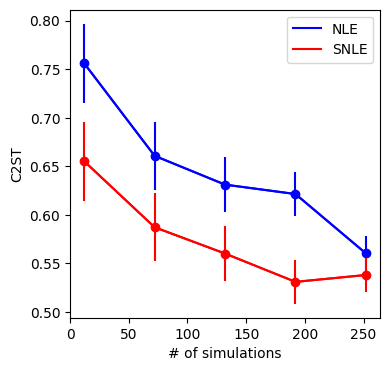

In [96]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.plot(n_sims_range, nle_means, c='b', label='NLE')
ax.scatter(n_sims_range, nle_means, c='b')
ax.errorbar(n_sims_range, nle_means, yerr=snle_stds, c='b')

ax.plot(n_sims_range, snle_means, c='r', label='SNLE')
ax.scatter(n_sims_range, snle_means, c='r')
ax.errorbar(n_sims_range, snle_means, yerr=snle_stds, c='r')

ax.plot(n_sims_range, snle_means, c='g', label='emnets')
ax.scatter(n_sims_range, snle_means, c='g')
ax.errorbar(n_sims_range, snle_means, yerr=snle_stds, c='emnets')

ax.set_xlabel('# of simulations')
ax.set_ylabel('C2ST')
plt.legend()
plt.tight_layout()
plt.show()

In [127]:
def run_emnets_comparison(simulator, 
                          prior, 
                          obs, 
                          n_aq, 
                          n_samples=1000, 
                          n_repeats=3, 
                          n_emulators=5, 
                          n_init_sims=25):
    prior, num_parameters, prior_returns_numpy = process_prior(prior)
    simulator = process_simulator(gaussian_simulator, prior, prior_returns_numpy)
    mcmc_samples = get_posterior_samples(prior, gaussian_simulator, obs, n_samples=n_samples)
    c2st_means, c2st_std = [],[]
    for n in trange(n_aq):
        c = []
        n_sims_init = 25
        for _ in range(n_repeats):
            # init training
            emulators = [NLE(prior=prior, show_progress_bars=False) for _ in range(n_emulators)]
            theta, x = simulate_for_sbi(simulator, prior, num_simulations=n_sims_init, show_progress_bar=False)
            ensemble = []
            for inference in emulators:
                density_estimator = inference.append_simulations(theta, x).train()
                posterior = inference.build_posterior(density_estimator)
                ensemble.append(posterior)
            ensemble_posterior = EnsemblePosterior(ensemble)
            for _ in range(n):
                proposal = ensemble_posterior.set_default_x(obs)
                theta_prop = proposal.sample((100,))
                likelihood_matrix = np.array([e.log_prob(theta_prop, obs).numpy() for e in ensemble])
                theta_star = theta_prop[np.argmax(likelihood_matrix.var(axis=0))]
                x = gaussian_simulator(theta_star)
                x = th.Tensor(x)
                ensemble = []
                for inference in emulators:
                    print('x: ', x)
                    print('theta: ', theta_star)
                    density_estimator = inference.append_simulations(theta_star, x).train()
                    # this is wrong -- build ensemble of likelihoods
                    posterior = inference.build_posterior(density_estimator)
                    ensemble.append(posterior)
                ensemble_posterior = EnsemblePosterior(ensemble)
            samples = ensemble_posterior.sample((n_samples,), x=obs, show_progress_bars=False)
            c.append(c2st(samples, mcmc_samples).item())
        c = np.array(c)
        c2st_means.append(c.mean())
        c2st_std.append(c.std())

    return c2st_means, c2st_std

In [128]:
emnets_means, emnets_stds = run_emnets_comparison(gaussian_simulator, prior, obs, 25)

  0%|          | 0/25 [00:00<?, ?it/s]

 Neural network successfully converged after 45 epochs..

Running vectorized MCMC with 20 chains:   0%|          | 0/5040 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5040 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5040 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5020 [00:00<?, ?it/s]

x:  tensor([-3.6080])
theta:  tensor([-6.5112])


RuntimeError: Tensors must have same number of dimensions: got 2 and 1

In [ ]:
def run_nle_comparison(simulator, prior, obs, n_sims_range, n_samples=1000, n_repeats=5):
    prior, num_parameters, prior_returns_numpy = process_prior(prior)
    simulator = process_simulator(gaussian_simulator, prior, prior_returns_numpy)
    mcmc_samples = get_posterior_samples(prior, gaussian_simulator, obs, n_samples=n_samples)
    c2st_means, c2st_std = [],[]
    for n in tqdm(n_sims_range):
        c = []
        for _ in range(n_repeats):
            inference = NLE(prior=prior)
            theta, x = simulate_for_sbi(simulator, prior, num_simulations=n, show_progress_bar=False)
            density_estimator = inference.append_simulations(theta, x).train(show_train_summary=False)
            posterior = inference.build_posterior(density_estimator)
            nle_samples = posterior.sample((n_samples,), x=obs, show_progress_bars=False)
            c.append(c2st(nle_samples, mcmc_samples).item())
        c = np.array(c)
        c2st_means.append(c.mean())
        c2st_std.append(c.std())

    return c2st_means, c2st_std


def run_snle_comparison(simulator, prior, obs, n_sims_range, n_samples=1000, n_repeats=5):
    prior, num_parameters, prior_returns_numpy = process_prior(prior)
    simulator = process_simulator(gaussian_simulator, prior, prior_returns_numpy)
    mcmc_samples = get_posterior_samples(prior, gaussian_simulator, obs, n_samples=n_samples)
    c2st_means, c2st_std = [],[]
    for n in tqdm(n_sims_range):
        c = []
        n_rounds = 3
        init_pct = .5
        n_sims_init = int(n * init_pct)
        n_sims_round = int((n - n_sims_init) / n_rounds)
        for _ in range(n_repeats):
            # init training
            inference = NLE(prior=prior)
            theta, x = simulate_for_sbi(simulator, prior, num_simulations=n_sims_init, show_progress_bar=False)
            density_estimator = inference.append_simulations(theta, x).train(show_train_summary=False)
            posterior = inference.build_posterior(density_estimator)
            for _ in range(n_rounds):
                proposal = posterior.set_default_x(obs)
                theta, x = simulate_for_sbi(simulator, proposal, num_simulations=n_sims_round, show_progress_bar=False)
                density_estimator = inference.append_simulations(theta, x).train(show_train_summary=False)
                posterior = inference.build_posterior(density_estimator)
            nle_samples = posterior.sample((n_samples,), x=obs, show_progress_bars=False)
            c.append(c2st(nle_samples, mcmc_samples).item())
        c = np.array(c)
        c2st_means.append(c.mean())
        c2st_std.append(c.std())

    return c2st_means, c2st_std

def run_emnets_comparison(simulator, prior, obs, n_sims_range, n_samples=1000, n_repeats=5, n_emulators=3):
    prior, num_parameters, prior_returns_numpy = process_prior(prior)
    simulator = process_simulator(gaussian_simulator, prior, prior_returns_numpy)
    mcmc_samples = get_posterior_samples(prior, gaussian_simulator, obs, n_samples=n_samples)
    c2st_means, c2st_std = [],[]
    for n in tqdm(n_sims_range):
        c = []
        n_rounds = 3
        init_pct = .5
        n_sims_init = int(n * init_pct)
        n_sims_round = int((n - n_sims_init) / n_rounds)
        for _ in range(n_repeats):
            # init training
            emulators = [NLE(prior=prior, show_progress_bars=False) for _ in range(n_emulators)]
            theta, x = simulate_for_sbi(simulator, prior, num_simulations=n_sims_init, show_progress_bar=False)
            ensemble = []
            for inference in emulators:
                density_estimator = inference.append_simulations(theta, x).train()
                posterior = inference.build_posterior(density_estimator)
                ensemble.append(posterior)
            ensemble_posterior = EnsemblePosterior(ensemble)
            for _ in range(n_rounds):
                proposal = ensemble_posterior.set_default_x(obs)
                theta, x = simulate_for_sbi(simulator, proposal, num_simulations=n_sims_round, show_progress_bar=False)
                ensemble = []
                for inference in emulators:
                    density_estimator = inference.append_simulations(theta, x).train()
                    posterior = inference.build_posterior(density_estimator)
                    ensemble.append(posterior)
                ensemble_posterior = EnsemblePosterior(ensemble)
            samples = posterior.sample((n_samples,), x=obs, show_progress_bars=False)
            c.append(c2st(samples, mcmc_samples).item())
        c = np.array(c)
        c2st_means.append(c.mean())
        c2st_std.append(c.std())

    return c2st_means, c2st_std

In [ ]:
def run_emnets_comparison(simulator, prior, obs, n_sims_range, n_samples=1000, n_repeats=3, n_emulators=5):
    prior, num_parameters, prior_returns_numpy = process_prior(prior)
    simulator = process_simulator(gaussian_simulator, prior, prior_returns_numpy)
    mcmc_samples = get_posterior_samples(prior, gaussian_simulator, obs, n_samples=n_samples)
    c2st_means, c2st_std = [],[]
    for n in trange:
        c = []
        n_sims_init = 25
        for _ in range(n_repeats):
            # init training
            emulators = [NLE(prior=prior, show_progress_bars=False) for _ in range(n_emulators)]
            theta, x = simulate_for_sbi(simulator, prior, num_simulations=n_sims_init, show_progress_bar=False)
            ensemble = []
            for inference in emulators:
                density_estimator = inference.append_simulations(theta, x).train()
                posterior = inference.build_posterior(density_estimator)
                ensemble.append(posterior)
            ensemble_posterior = EnsemblePosterior(ensemble)
            for _ in range(n_rounds):
                proposal = ensemble_posterior.set_default_x(obs)
                theta_prop = proposal.sample((100,))
                likelihood_matrix = np.array([e.log_prob(theta_prop, obs).numpy() for e in ensemble)])
                theta_star = theta_prop[np.argmax(likelihood_matrix.var(axis=0))]
                x = gaussian_simulator(theta_star, n=1)
                x = th.Tensor(x).unsqueeze(-1)
                ensemble = []
                for inference in emulators:
                    density_estimator = inference.append_simulations(theta_star, x).train()
                    posterior = inference.build_posterior(density_estimator)
                    ensemble.append(posterior)
                ensemble_posterior = EnsemblePosterior(ensemble)
            samples = ensemble_posterior.sample((n_samples,), x=obs, show_progress_bars=False)
            c.append(c2st(samples, mcmc_samples).item())
        c = np.array(c)
        c2st_means.append(c.mean())
        c2st_std.append(c.std())

    return c2st_means, c2st_std

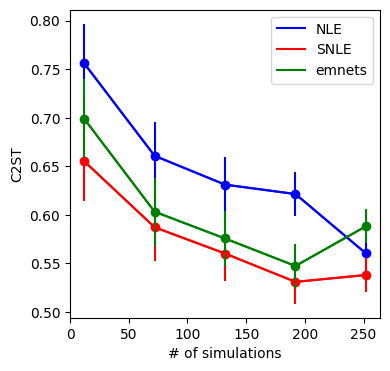

In [110]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.plot(n_sims_range, nle_means, c='b', label='NLE')
ax.scatter(n_sims_range, nle_means, c='b')
ax.errorbar(n_sims_range, nle_means, yerr=snle_stds, c='b')

ax.plot(n_sims_range, snle_means, c='r', label='SNLE')
ax.scatter(n_sims_range, snle_means, c='r')
ax.errorbar(n_sims_range, snle_means, yerr=snle_stds, c='r')

ax.plot(n_sims_range, emnets_means, c='g', label='emnets')
ax.scatter(n_sims_range, emnets_means, c='g')
ax.errorbar(n_sims_range, emnets_means, yerr=snle_stds, c='g')

ax.set_xlabel('# of simulations')
ax.set_ylabel('C2ST')
plt.legend()
plt.show()

In [ ]:

# Consistency check after making ready for sbi.
check_sbi_inputs(simulator, prior)

n_emulators = 3
emulators = [NLE(prior=prior, show_progress_bars=False) for _ in range(n_emulators)]

# 2 rounds: first round simulates from the prior, second round simulates parameter set
# that were sampled from the obtained posterior.
num_rounds = 10
# The specific observation we want to focus the inference on.
x_o = th.tensor([2.5])

posteriors = []
proposal = prior

for _ in range(num_rounds):
    ensemble = []
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=50, show_progress_bar=False)
    # In `SNLE` and `SNRE`, you should not pass the `proposal` to `.append_simulations()`
    for inference in emulators:
        density_estimator = inference.append_simulations(
            theta, x
        ).train()
        posterior = inference.build_posterior(density_estimator)
        ensemble.append(posterior)
    ensemble_posterior = EnsemblePosterior(ensemble)
    proposal = posterior.set_default_x(x_o)
    posteriors.append(ensemble_posterior)

samples = ensemble_posterior.sample((10000,), x=x_obs)
_ = pairplot(samples,
             limits=[[-12, 12], [-12, 12], [-12, 12]],
             figsize=(4, 4),
             labels=[r"$\theta_1$"])

In [54]:
def generate(prior, simulator, obs, n_sims, n_samples, n_repeats):
    # validate prior and simulator for sbi
    prior, num_parameters, prior_returns_numpy = process_prior(prior)
    simulator = process_simulator(gaussian_simulator, prior, prior_returns_numpy)
    # generate ground truth samples
    mcmc_samples = get_posterior_samples(prior, gaussian_simulator, obs, n_samples=n_samples)
    c2st_means, c2st_std = [],[]
    for n in n_sims:
        scores = []
        theta, x = simulate_for_sbi(simulator, prior, num_simulations=n)
        for _ in range(n_repeats):
            inference = NLE(prior=prior)
            density_estimator = inference.append_simulations(theta, x).train()
            posterior = inference.build_posterior(density_estimator)
            nle_samples = posterior.sample((n_samples,), x=obs)
            c.append(c2st(nle_samples, mcmc_samples).item())
        scores = np.array(c)
        c2st_means.append(scores.mean())
        c2st_std.append(scores.std())

In [35]:
th.tensor([2.23]).item()

2.2300000190734863

In [53]:
n_repeats = 5
#n_samples = 10000
n_samples = 1000
obs = th.tensor([3])
prior = BoxUniform(low=-8 * th.ones(1), high=8 * th.ones(1)) 
prior, num_parameters, prior_returns_numpy = process_prior(prior)
simulator = process_simulator(gaussian_simulator, prior, prior_returns_numpy)
mcmc_samples = get_posterior_samples(prior, gaussian_simulator, obs, n_samples=n_samples)
n_sims_range = np.arange(5, 205, 50)
c2st_means, c2st_std = [],[]
for n in n_sims_range:
    c = []
    theta, x = simulate_for_sbi(simulator, prior, num_simulations=n)
    for _ in range(n_repeats):
        inference = NLE(prior=prior)
        density_estimator = inference.append_simulations(theta[:n], x[:n]).train()
        posterior = inference.build_posterior(density_estimator)
        nle_samples = posterior.sample((n_samples,), x=th.tensor([3]))
        c.append(c2st(nle_samples, mcmc_samples).item())
    c = np.array(c)
    c2st_means.append(c.mean())
    c2st_std.append(c.std())

Running 100000 simulations.:   0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 108 epochs.

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/6000 [00:00<?, ?it/s]

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 89 epochs.

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/6000 [00:00<?, ?it/s]

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 97 epochs.

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/6000 [00:00<?, ?it/s]

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 49 epochs.

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/6000 [00:00<?, ?it/s]

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 65 epochs.

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 39 epochs.

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/6000 [00:00<?, ?it/s]

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 120 epochs.

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/6000 [00:00<?, ?it/s]

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 98 epochs.

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/6000 [00:00<?, ?it/s]

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 40 epochs.

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/6000 [00:00<?, ?it/s]

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 127 epochs.

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 120 epochs.

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/6000 [00:00<?, ?it/s]

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 52 epochs.

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/6000 [00:00<?, ?it/s]

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 170 epochs.

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/6000 [00:00<?, ?it/s]

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 53 epochs.

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/6000 [00:00<?, ?it/s]

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 107 epochs.

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 87 epochs.

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/6000 [00:00<?, ?it/s]

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 80 epochs.

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/6000 [00:00<?, ?it/s]

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 230 epochs.

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/6000 [00:00<?, ?it/s]

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 210 epochs.

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/6000 [00:00<?, ?it/s]

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 76 epochs.

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 72 epochs.

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/6000 [00:00<?, ?it/s]

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 192 epochs.

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/6000 [00:00<?, ?it/s]

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 182 epochs.

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/6000 [00:00<?, ?it/s]

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 195 epochs.

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/6000 [00:00<?, ?it/s]

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 40 epochs.

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 70 epochs.

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/6000 [00:00<?, ?it/s]

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 75 epochs.

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/6000 [00:00<?, ?it/s]

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 263 epochs.

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/6000 [00:00<?, ?it/s]

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 196 epochs.

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/6000 [00:00<?, ?it/s]

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 82 epochs.

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/305 [00:00<?, ?it/s]

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 70 epochs.

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/6000 [00:00<?, ?it/s]

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 205 epochs.

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/6000 [00:00<?, ?it/s]

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 225 epochs.

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/6000 [00:00<?, ?it/s]

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 71 epochs.

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/6000 [00:00<?, ?it/s]

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 262 epochs.

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/6000 [00:00<?, ?it/s]

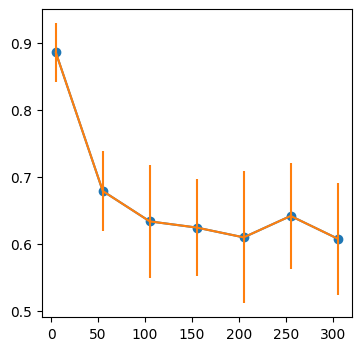

In [55]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(n_sims_range, c2st_means)
ax.scatter(n_sims_range, c2st_means)
ax.errorbar(n_sims_range, c2st_means, yerr=c2st_std)
plt.show()

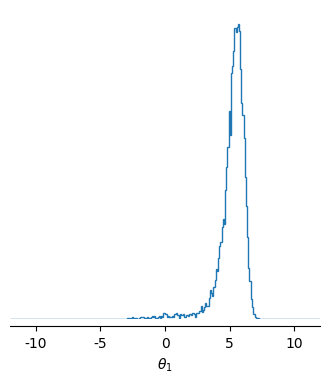

In [12]:
_ = pairplot(nle_samples,
             limits=[[-12, 12], [-12, 12], [-12, 12]],
             figsize=(4, 4),
             labels=[r"$\theta_1$"]
            )

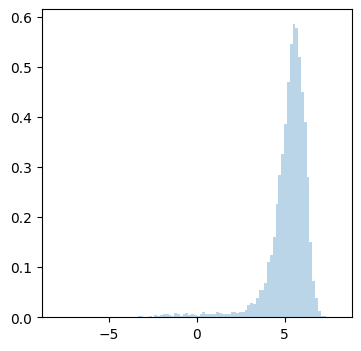

In [13]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(mcmc_samples, range=((-8, 8)), bins=100, density=True, alpha=.3)
plt.show()

In [16]:
c2st(nle_samples, mcmc_samples)

tensor([0.5125])

In [29]:
inference = NLE(prior=prior, show_progress_bars=False)
theta, x = simulate_for_sbi(simulator, prior, num_simulations=10000, show_progress_bar=True)
density_estimator = inference.append_simulations(
        theta, x
    ).train()
posterior = inference.build_posterior(density_estimator)
nle_samples = posterior.sample((50000,), x=th.tensor([3]))

  0%|          | 0/10000 [00:00<?, ?it/s]

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 96 epochs.

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/55000 [00:00<?, ?it/s]

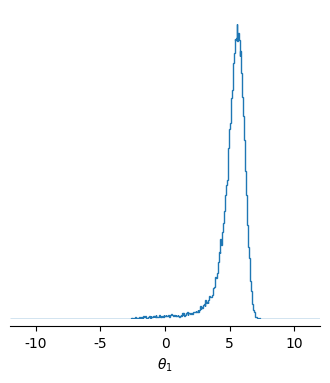

In [33]:
_ = pairplot(nle_samples,
             limits=[[-12, 12], [-12, 12], [-12, 12]],
             figsize=(4, 4),
             labels=[r"$\theta_1$"]
            )

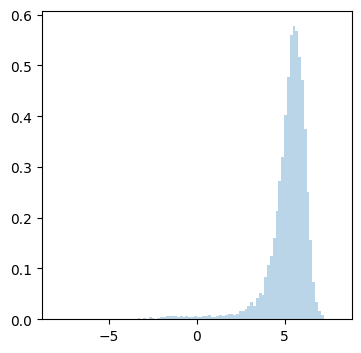

In [35]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(mcmc_samples, range=((-8, 8)), bins=100, density=True, alpha=.3)
plt.show()

In [36]:
from sbibm.metrics import c2st

c2st(nle_samples, mcmc_samples)

tensor([0.8333])

In [5]:
from sbi.inference import MCABC

observation = th.tensor([3])


prior = BoxUniform(low=-8 * th.ones(1), high=8 * th.ones(1))
prior, num_parameters, prior_returns_numpy = process_prior(prior)
simulator = process_simulator(gaussian_simulator, prior, prior_returns_numpy)
check_sbi_inputs(simulator, prior)

inference_method = MCABC(
    simulator=simulator,
    prior=prior,
    #simulation_batch_size=batch_size,
    #distance=distance,
    show_progress_bars=True,
)

output, summary = inference_method(
    x_o=observation,
    num_simulations=5000000,
    #eps=eps,
    quantile=.01,
    return_summary=True,
    #kde=kde,
    #kde_kwargs={"bandwidth": kde_bandwidth} if kde else {},
    #lra=lra,
    #sass=sass,
    #sass_expansion_degree=sass_feature_expansion_degree,
    #sass_fraction=sass_fraction,
)

Running 5000000 simulations.:   0%|          | 0/5000000 [00:00<?, ?it/s]

In [16]:
output.shape

torch.Size([50000, 1])

In [7]:
inference = NLE(prior=prior, show_progress_bars=False)
theta, x = simulate_for_sbi(simulator, prior, num_simulations=10000, show_progress_bar=True)
density_estimator = inference.append_simulations(
        theta, x
    ).train()
posterior = inference.build_posterior(density_estimator)
samples = posterior.sample((50000,), x=th.tensor([3]))

  0%|          | 0/10000 [00:00<?, ?it/s]

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 76 epochs.

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/55000 [00:00<?, ?it/s]

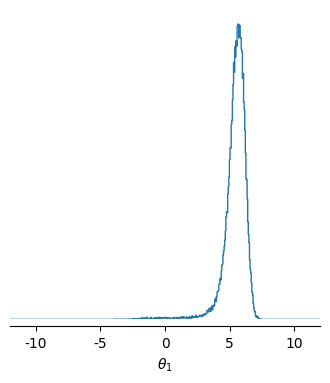

In [17]:
_ = pairplot(samples,
             limits=[[-12, 12], [-12, 12], [-12, 12]],
             figsize=(4, 4),
             labels=[r"$\theta_1$"]
            )

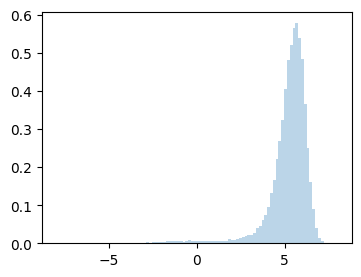

In [18]:
fig, ax = plt.subplots(figsize=(4, 3))

ax.hist(output, range=((-8, 8)), bins=100, density=True, alpha=.3)

plt.show()

In [15]:
from sbibm.metrics import c2st

c2st(output, samples)

tensor([0.5480])

tensor([0.5480])

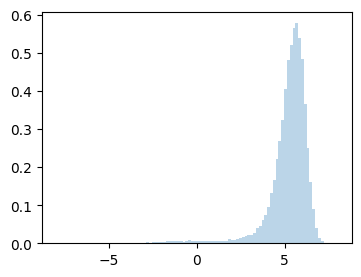

In [11]:
fig, ax = plt.subplots(figsize=(4, 3))

ax.hist(output, range=((-8, 8)), bins=100, density=True, alpha=.3)

plt.show()

In [ ]:
C

In [17]:
from sbibm.tasks import Task

class GaussianCubic1D(Task):
    def __init__(self):
        pass




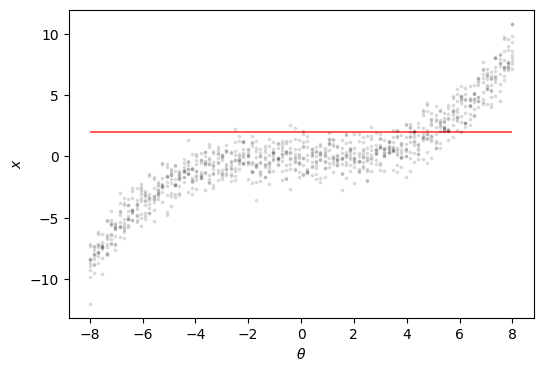

In [2]:
fig, ax = plt.subplots(figsize=(6, 4))

x_obs = 2

for theta in np.linspace(-8, 8, 100):
    x = gaussian_simulator(theta, n=10)
    ax.scatter(theta.repeat(len(x)), x, c='black', alpha=.1, s=3)
    ax.set_xlabel(r'$\theta$')
    ax.set_ylabel(r'$x$')

    plt.plot([-8, 8],[x_obs, x_obs], color='red', linewidth=.1, alpha=.1)

plt.show()

In [11]:
theta.mean()

tensor(4.8495)

In [14]:
# Define prior distribution
prior = BoxUniform(low=-8 * th.ones(1), high=8 * th.ones(1))

# Check prior, return PyTorch prior.
prior, num_parameters, prior_returns_numpy = process_prior(prior)

# Check simulator, returns PyTorch simulator able to simulate batches.
simulator = process_simulator(gaussian_simulator, prior, prior_returns_numpy)

# Consistency check after making ready for sbi.
check_sbi_inputs(simulator, prior)
inference = NLE(prior=prior, show_progress_bars=False)
theta, x = simulate_for_sbi(simulator, proposal, num_simulations=10000, show_progress_bar=False)
density_estimator = inference.append_simulations(
        theta, x
    ).train()
posterior = inference.build_posterior(density_estimator)

Running vectorized MCMC with 20 chains:   0%|          | 0/15000 [00:00<?, ?it/s]

 Neural network successfully converged after 64 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/15000 [00:00<?, ?it/s]

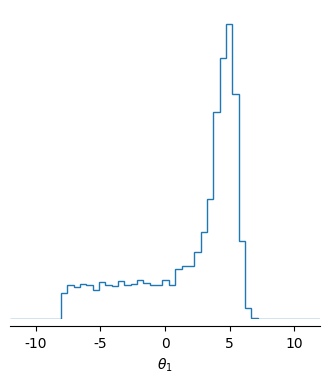

In [16]:
samples = posterior.sample((10000,), x=x_obs)
_ = pairplot(samples,
             limits=[[-12, 12], [-12, 12], [-12, 12]],
             figsize=(4, 4),
             labels=[r"$\theta_1$"]
            )

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 42 epochs.

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)
/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 36 epochs..

Running vectorized MCMC with 20 chains:   0%|          | 0/5060 [00:00<?, ?it/s]

 Neural network successfully converged after 50 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5060 [00:00<?, ?it/s]

 Neural network successfully converged after 44 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5060 [00:00<?, ?it/s]

 Neural network successfully converged after 44 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5060 [00:00<?, ?it/s]

 Neural network successfully converged after 32 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5060 [00:00<?, ?it/s]

 Neural network successfully converged after 33 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5060 [00:00<?, ?it/s]

 Neural network successfully converged after 61 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5060 [00:00<?, ?it/s]

 Neural network successfully converged after 49 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5060 [00:00<?, ?it/s]

 Neural network successfully converged after 168 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5060 [00:00<?, ?it/s]

 Neural network successfully converged after 88 epochs..

Running vectorized MCMC with 20 chains:   0%|          | 0/8340 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/8360 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/8340 [00:00<?, ?it/s]

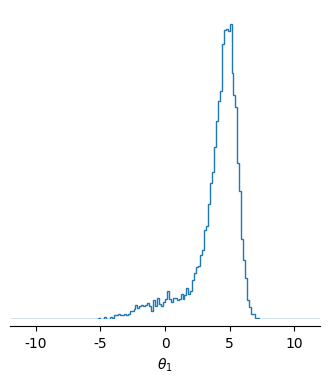

In [3]:
# Define prior distribution
prior = BoxUniform(low=-8 * th.ones(1), high=8 * th.ones(1))

# Check prior, return PyTorch prior.
prior, num_parameters, prior_returns_numpy = process_prior(prior)

# Check simulator, returns PyTorch simulator able to simulate batches.
simulator = process_simulator(gaussian_simulator, prior, prior_returns_numpy)

# Consistency check after making ready for sbi.
check_sbi_inputs(simulator, prior)

n_emulators = 3
emulators = [NLE(prior=prior, show_progress_bars=False) for _ in range(n_emulators)]

# 2 rounds: first round simulates from the prior, second round simulates parameter set
# that were sampled from the obtained posterior.
num_rounds = 10
# The specific observation we want to focus the inference on.
x_o = th.tensor([2.5])

posteriors = []
proposal = prior

for _ in range(num_rounds):
    ensemble = []
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=50, show_progress_bar=False)
    # In `SNLE` and `SNRE`, you should not pass the `proposal` to `.append_simulations()`
    for inference in emulators:
        density_estimator = inference.append_simulations(
            theta, x
        ).train()
        posterior = inference.build_posterior(density_estimator)
        ensemble.append(posterior)
    ensemble_posterior = EnsemblePosterior(ensemble)
    proposal = posterior.set_default_x(x_o)
    posteriors.append(ensemble_posterior)

samples = ensemble_posterior.sample((10000,), x=x_obs)
_ = pairplot(samples,
             limits=[[-12, 12], [-12, 12], [-12, 12]],
             figsize=(4, 4),
             labels=[r"$\theta_1$"])

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 307 epochs.

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/15000 [00:00<?, ?it/s]

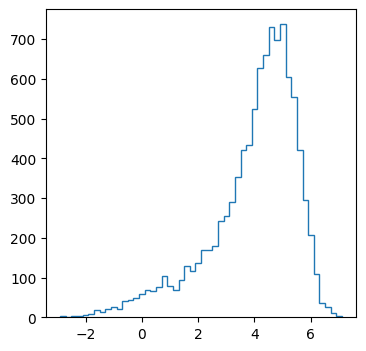

In [4]:
num_dim = 1
prior = BoxUniform(low=-8 * th.ones(num_dim), high=8 * th.ones(num_dim))

# Check prior, return PyTorch prior.
prior, num_parameters, prior_returns_numpy = process_prior(prior)

# Check simulator, returns PyTorch simulator able to simulate batches.
simulator = process_simulator(gaussian_simulator, prior, prior_returns_numpy)

# Consistency check after making ready for sbi.
check_sbi_inputs(simulator, prior)

inference = NLE(prior=prior)

num_simulations = 100
theta = prior.sample((num_simulations,))
x = simulator(theta)

inference = inference.append_simulations(theta, x)
density_estimator = inference.train()

posterior = inference.build_posterior(density_estimator)

samples = posterior.sample((10000,), x=x_obs)

fig, ax = plt.subplots(figsize=(4, 4))
counts, bins = np.histogram(samples, bins=50)
plt.stairs(counts, bins)

In [14]:
theta = prior.sample((1,))
x = simulator(theta)

posterior.log_prob(theta, x)

/var/folders/f3/d5xwhmfs3tz1mx_rvf_24qb80000gn/T/ipykernel_58200/2957125430.py:4: UserWarning: `.log_prob()` is deprecated for methods that can only evaluate the log-probability up to a normalizing constant. Use `.potential()` instead.
  posterior.log_prob(theta, x)
/var/folders/f3/d5xwhmfs3tz1mx_rvf_24qb80000gn/T/ipykernel_58200/2957125430.py:4: UserWarning: The log-probability is unnormalized!
  posterior.log_prob(theta, x)


tensor([-3.8163])

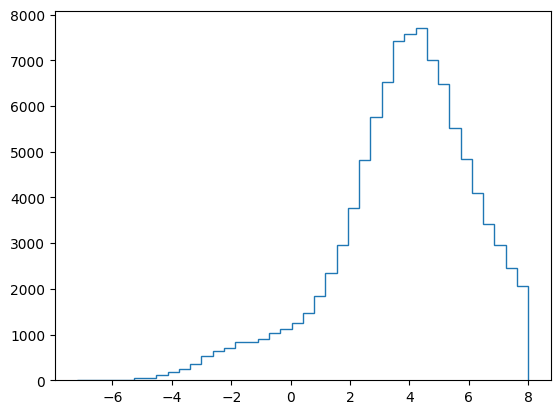

In [6]:
counts, bins = np.histogram(samples, bins=40)
plt.stairs(counts, bins)

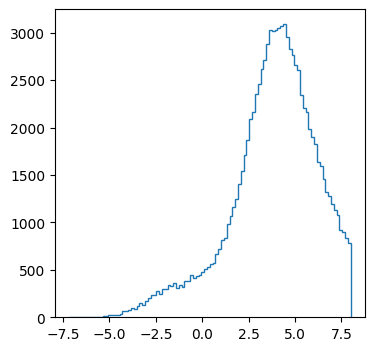

In [10]:
fig, ax = plt.subplots(figsize=(4, 4))
counts, bins = np.histogram(samples, bins=100)
plt.stairs(counts, bins)

In [5]:
inference = NLE(prior=prior)

In [6]:
num_simulations = 100
theta = prior.sample((num_simulations,))
x = simulator(theta)
print("theta.shape", theta.shape)
print("x.shape", x.shape)

theta.shape torch.Size([100, 1])
x.shape torch.Size([100, 1])


In [7]:
inference = inference.append_simulations(theta, x)

In [8]:
density_estimator = inference.train()

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 51 epochs.

In [9]:
posterior = inference.build_posterior(density_estimator)

print(posterior) # prints how the posterior was trained

Posterior p(θ|x) of type MCMCPosterior. It provides MCMC to .sample() from the posterior and can evaluate the _unnormalized_ posterior density with .log_prob().


/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


In [10]:
#theta_true = prior.sample((1,))
# generate our observation
#x_obs = simulator(theta_true)

Running vectorized MCMC with 20 chains:   0%|          | 0/15000 [00:00<?, ?it/s]

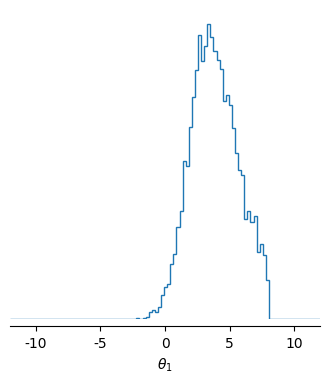

In [13]:
samples = posterior.sample((10000,), x=x_obs)
_ = pairplot(samples,
             limits=[[-12, 12], [-12, 12], [-12, 12]],
             figsize=(4, 4),
             labels=[r"$\theta_1$"])

 Neural network successfully converged after 57 epochs..

Running vectorized MCMC with 20 chains:   0%|          | 0/5060 [00:00<?, ?it/s]

 Neural network successfully converged after 159 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5060 [00:00<?, ?it/s]

 Neural network successfully converged after 41 epochs..

Running vectorized MCMC with 20 chains:   0%|          | 0/5060 [00:00<?, ?it/s]

 Neural network successfully converged after 38 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5060 [00:00<?, ?it/s]

 Neural network successfully converged after 22 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5060 [00:00<?, ?it/s]

 Neural network successfully converged after 56 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5060 [00:00<?, ?it/s]

 Neural network successfully converged after 33 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5060 [00:00<?, ?it/s]

 Neural network successfully converged after 28 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5060 [00:00<?, ?it/s]

 Neural network successfully converged after 21 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/5060 [00:00<?, ?it/s]

 Neural network successfully converged after 26 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/8340 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/8380 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/8320 [00:00<?, ?it/s]

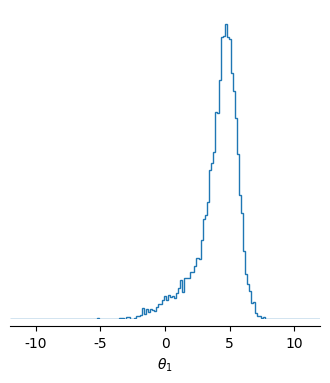

In [34]:
from sbi.inference.posteriors.ensemble_posterior import EnsemblePosterior
from sbi.utils.simulation_utils import simulate_for_sbi


num_dim = 1
prior = BoxUniform(low=-8 * th.ones(num_dim), high=8 * th.ones(num_dim))

# Check prior, return PyTorch prior.
prior, num_parameters, prior_returns_numpy = process_prior(prior)

# Check simulator, returns PyTorch simulator able to simulate batches.
simulator = process_simulator(gaussian_simulator, prior, prior_returns_numpy)

# Consistency check after making ready for sbi.
check_sbi_inputs(simulator, prior)

n_emulators = 3
emulators = [NLE(prior=prior, show_progress_bars=False) for _ in range(n_emulators)]

# 2 rounds: first round simulates from the prior, second round simulates parameter set
# that were sampled from the obtained posterior.
num_rounds = 10
# The specific observation we want to focus the inference on.
x_o = th.tensor([2.5])

posteriors = []
proposal = prior

for _ in range(num_rounds):
    ensemble = []
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=50, show_progress_bar=False)
    # In `SNLE` and `SNRE`, you should not pass the `proposal` to `.append_simulations()`
    for inference in emulators:
        density_estimator = inference.append_simulations(
            theta, x
        ).train()
        posterior = inference.build_posterior(density_estimator)
        ensemble.append(posterior)
    ensemble_posterior = EnsemblePosterior(ensemble)
    proposal = posterior.set_default_x(x_o)
    posteriors.append(ensemble_posterior)

samples = ensemble_posterior.sample((10000,), x=x_obs)
_ = pairplot(samples,
             limits=[[-12, 12], [-12, 12], [-12, 12]],
             figsize=(4, 4),
             labels=[r"$\theta_1$"])

 Neural network successfully converged after 206 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/15000 [00:00<?, ?it/s]

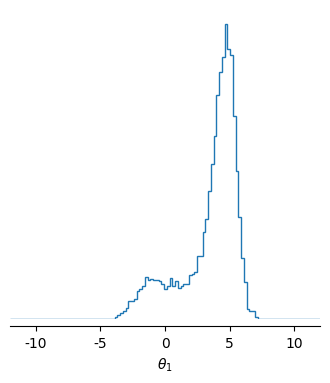

In [35]:
num_dim = 1
prior = BoxUniform(low=-8 * th.ones(num_dim), high=8 * th.ones(num_dim))

# Check prior, return PyTorch prior.
prior, num_parameters, prior_returns_numpy = process_prior(prior)

# Check simulator, returns PyTorch simulator able to simulate batches.
simulator = process_simulator(gaussian_simulator, prior, prior_returns_numpy)

# Consistency check after making ready for sbi.
check_sbi_inputs(simulator, prior)

inference = NLE(prior=prior)

num_simulations = 50 * 10
theta = prior.sample((num_simulations,))
x = simulator(theta)

inference = inference.append_simulations(theta, x)
density_estimator = inference.train()

posterior = inference.build_posterior(density_estimator)

samples = posterior.sample((10000,), x=x_obs)
_ = pairplot(samples,
             limits=[[-12, 12], [-12, 12], [-12, 12]],
             figsize=(4, 4),
             labels=[r"$\theta_1$"])

In [36]:
samples.shape

torch.Size([10000, 1])

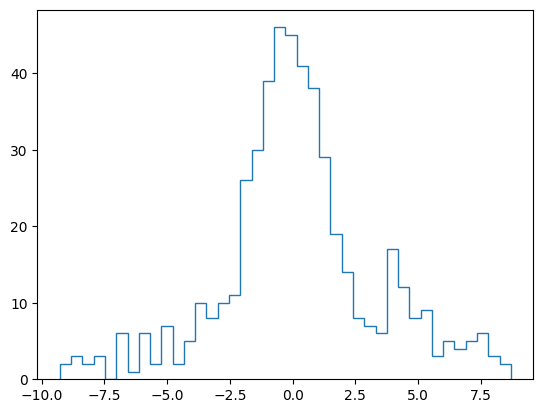

In [41]:
counts, bins = np.histogram(x, bins=40)
plt.stairs(counts, bins)